In [2]:
# This file contains all the main external libs we'll use
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../../fastai/") 
from math import radians, cos, sin, asin, sqrt
import os
import numpy as np
import pandas as pd
import gpxpy
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

#Directory where the aerial photos are
PHOTODIR="E:\\fj180\\fastai\\weeds\\weeds.aerial\\"
#which training architecture?
arch=resnet50
#Directory used for fats.ai training and validation
PATH="E:\\fj180\\fastai\\weeds\\weeds.aerial\\"
#File that comntains the waypoints that indicate weed locations
waypointFile = 'Waypoints_12-APR-18.gpx'
#Where to store the data from GPS analysis
label_csv=f'{PATH}labels.csv'
#Assuming the GPS co-ordinates are taken in the middle of the photo, a radius of 20m should be enough. 
#Estimate Photos are about 50m x 50m
radius = 0.02 # in kilometres
#Resize the images for the model
sz=224
#Batch size
batchSize=32
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=2.0)

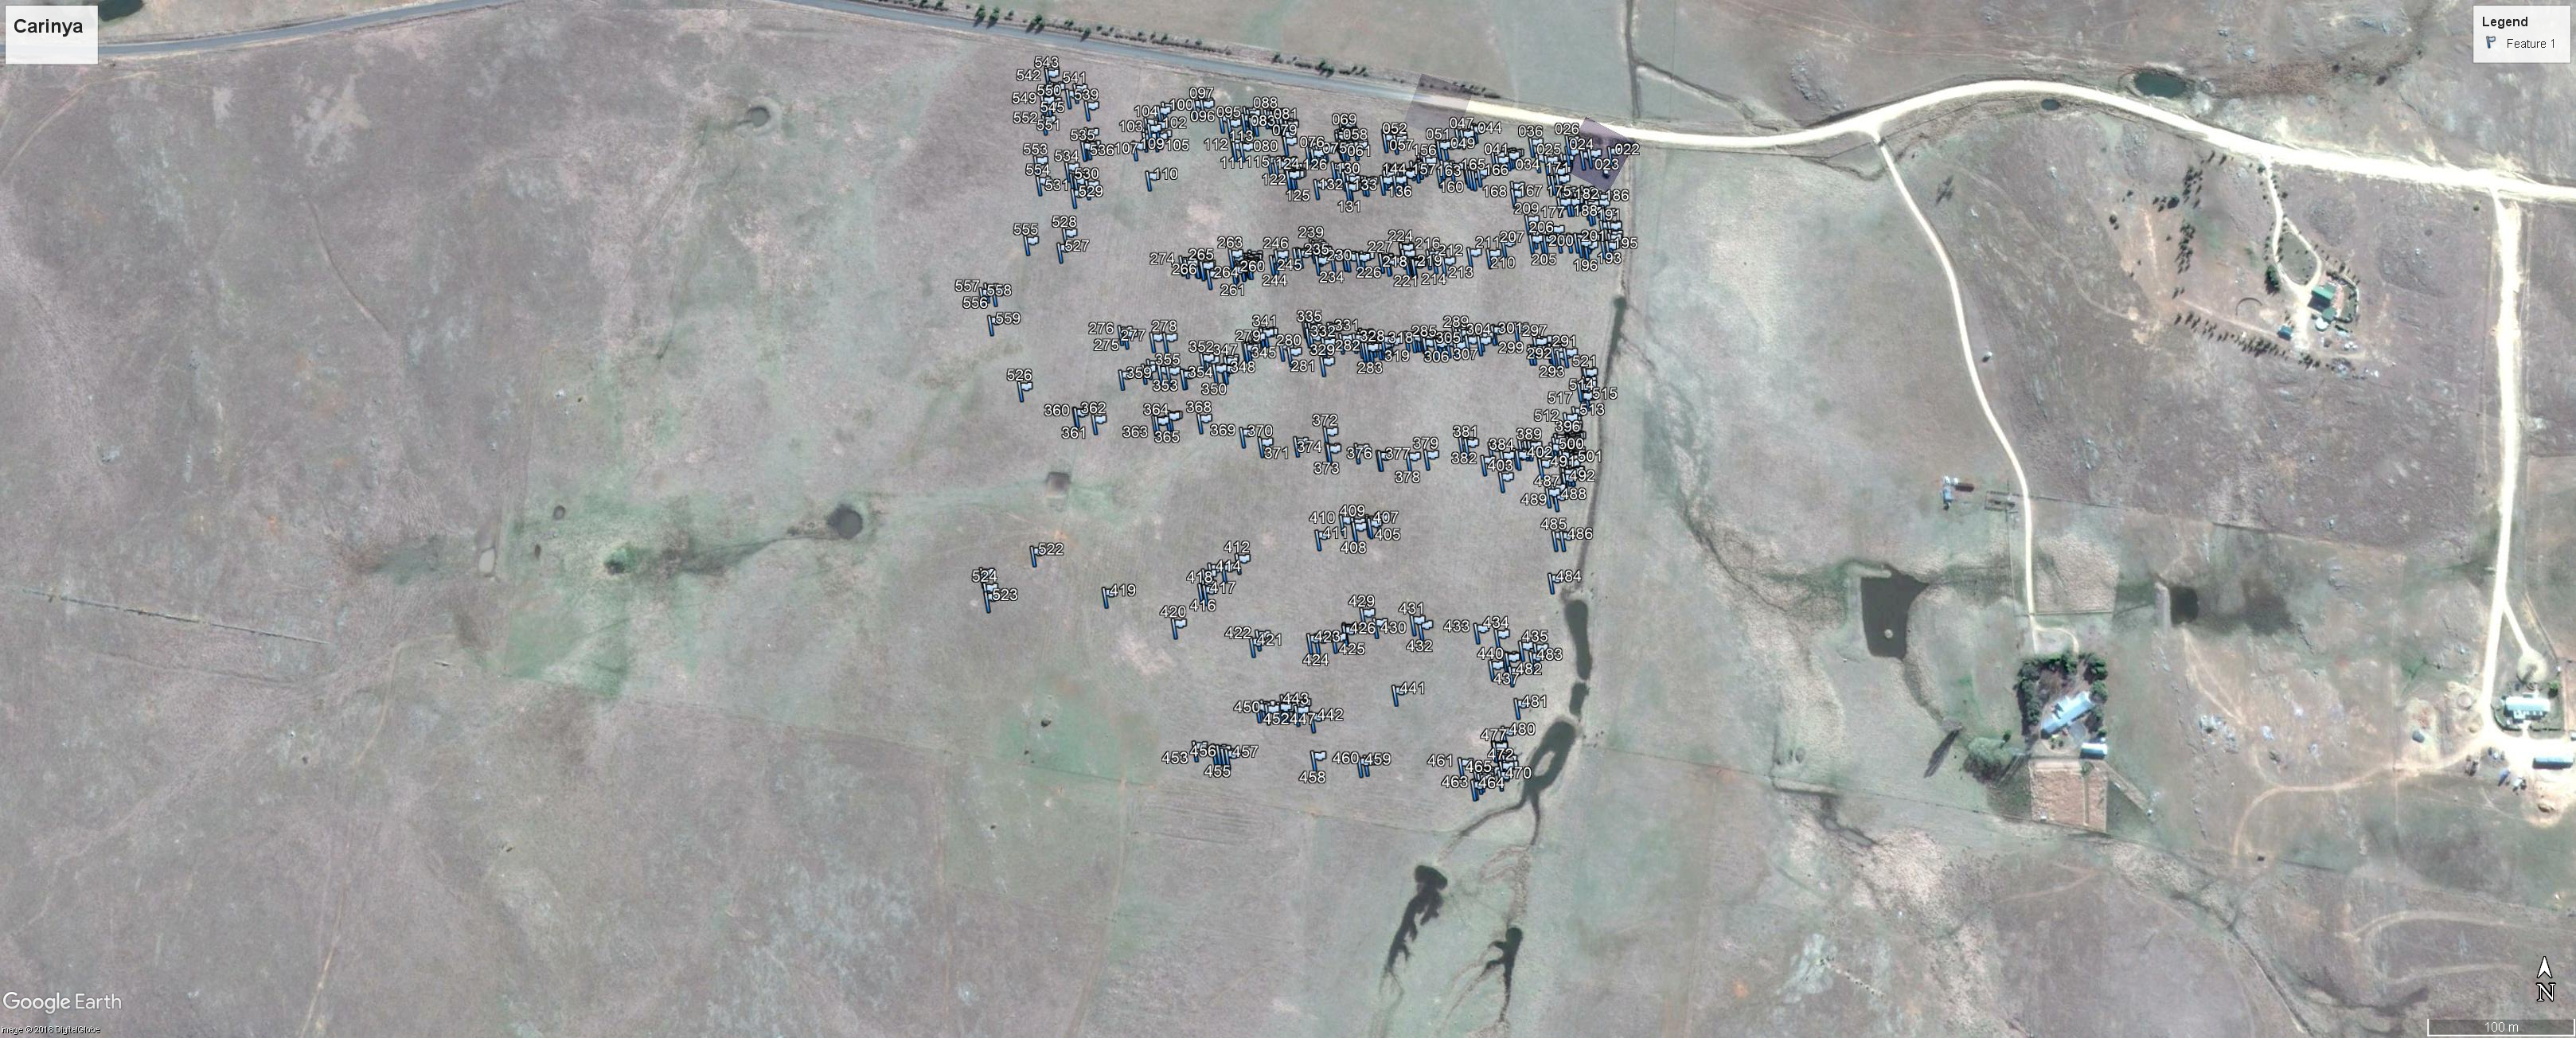

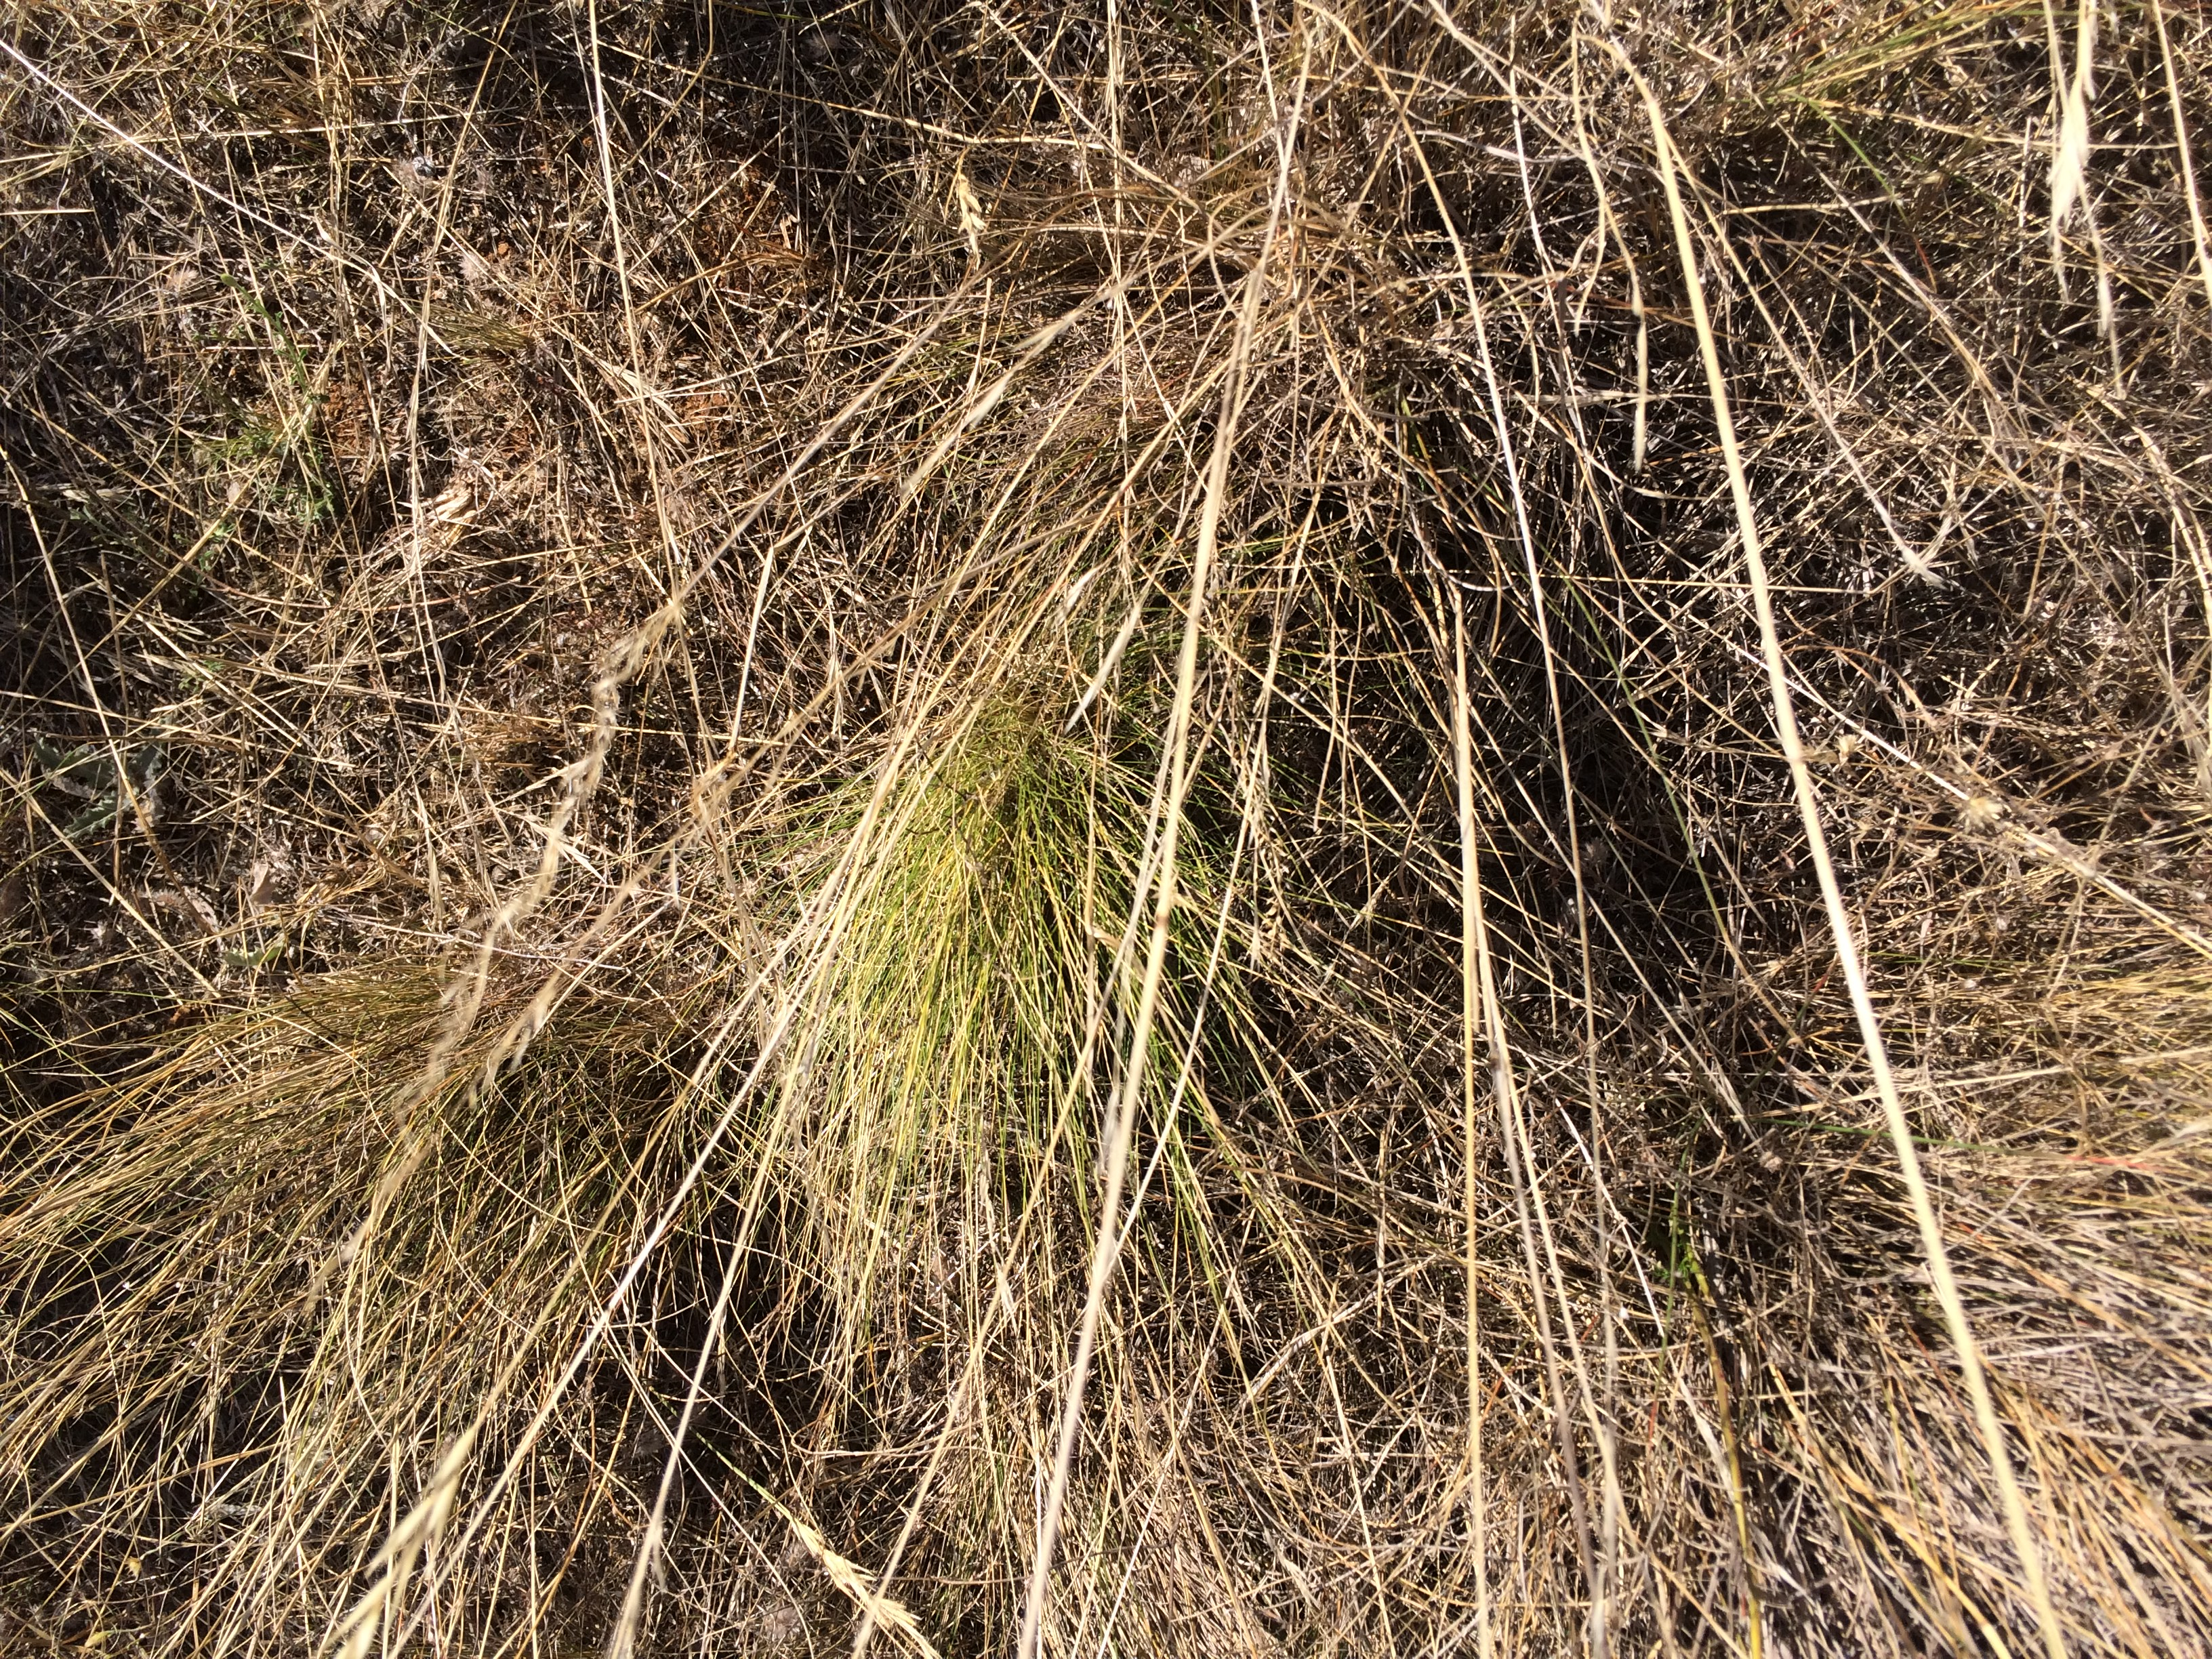

In [3]:
#We need to separate the drone photos into those that contain tussock, and those that don't.
#We'll do that by first processing the Garmin waypoints that Neil collected that showing the locations of serrated tussock

gpx = gpxpy.parse(open(waypointFile))

dfTussock = pd.DataFrame({'Latitude': [], 'Longitude': []})

for waypoint in gpx.waypoints:
    dfTussock = dfTussock.append ({'Latitude' : waypoint.latitude, 'Longitude' : waypoint.longitude}, ignore_index=True)

#there should be 538 records
#dfTussock.count

In [ ]:
#Now we are going to process the drone images and build a dataframe of their GPS locations
dfDroneLoc = pd.DataFrame({'Filename': [],'Latitude': [], 'Longitude': [], 'TussockFlag': []})

#Functions we'll use to get GPS data from the photos
def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    exif_data = {}
    info = image._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            if decoded == "GPSInfo":
                gps_data = {}
                for gps_tag in value:
                    sub_decoded = GPSTAGS.get(gps_tag, gps_tag)
                    gps_data[sub_decoded] = value[gps_tag]

                exif_data[decoded] = gps_data
            else:
                exif_data[decoded] = value

    return exif_data

def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    deg_num, deg_denom = value[0]
    d = float(deg_num) / float(deg_denom)

    min_num, min_denom = value[1]
    m = float(min_num) / float(min_denom)

    sec_num, sec_denom = value[2]
    s = float(sec_num) / float(sec_denom)
    
    return d + (m / 60.0) + (s / 3600.0)

def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:		
        gps_info = exif_data["GPSInfo"]

        gps_latitude = gps_info.get("GPSLatitude")
        gps_latitude_ref = gps_info.get('GPSLatitudeRef')
        gps_longitude = gps_info.get('GPSLongitude')
        gps_longitude_ref = gps_info.get('GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            lat = round(lat, 6)
            if gps_latitude_ref != "N":                     
                lat *= -1
                lat = round(lat, 6)

            lon = _convert_to_degress(gps_longitude)
            lon = round(lon, 6)
            if gps_longitude_ref != "E":
                lon *= -1
                lon = round(lon, 6)
    
    return lat, lon

#Now process the image files
dronePhotos = os.listdir(f'{PHOTODIR}')

for file in dronePhotos:
    img = Image.open(f'{PHOTODIR}\\{file}')
    exif_data = get_exif_data(img)
    dfDroneLoc = dfDroneLoc.append ({'Filename' : file, 'Latitude' : (get_lat_lon(exif_data)[0]), 'Longitude' : get_lat_lon(exif_data)[1]}, ignore_index=True)

dfDroneLoc.set_index('Filename', inplace=True)
#there should be 2238 records
#dfDroneLoc.count

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

#Now we are going to iterate through each drone photo and check is tussock has been identified within a given radius
for droneIndex, droneRow in dfDroneLoc.iterrows():
    lat1 = droneRow["Latitude"] 
    lon1 = droneRow["Longitude"]
    for tussockIndex, tussockRow in dfTussock.iterrows():
        lat2 = tussockRow["Latitude"]
        lon2 = tussockRow["Longitude"]
        a = haversine(lon1, lat1, lon2, lat2)
        #If a drone photo has a waypoint within given search radius, set the TussockFlag to True
        #If it doesn't, set TussockFlag to False
        if a <= radius:
            dfDroneLoc.loc[[droneIndex], "TussockFlag"] = True
                   
print ("Done")

In [ ]:
#Save the drone image dataframe to a csv file
dfDroneLoc.to_csv(os.path.join(PATH,label_csv),encoding='utf-8')

In [ ]:
#Now start doing some machine learning stuff
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                    tfms=tfms, val_idxs=get_cv_idxs(n), test_name='test', bs=batchSize)

In [ ]:
learn = ConvLearner.pretrained(arch, data)
%time learn.fit(1e-2, 3, cycle_len=2)

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
%time learn.fit ([1e-5,1e-4,1e-2],1,cycle_len=1)

In [ ]:
%time log_preds,y = learn.TTA()

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'no tussock' is label FALSE and 'tussock' is label TRUE.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(tussock)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct no tussock")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct tussock")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect no tussock")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect tussock")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
#learn.save("weedMap1")